# Voronoi Diagrams: Computational Geometry and Spatial Partitioning

## Introduction

A **Voronoi diagram** (also known as a Voronoi tessellation, Dirichlet tessellation, or Thiessen polygons) is a fundamental structure in computational geometry that partitions a plane into regions based on distance to a specified set of points called **sites** or **generators**.

## Mathematical Definition

Given a set of $n$ points $P = \{p_1, p_2, \ldots, p_n\}$ in a metric space (typically $\mathbb{R}^2$), the **Voronoi cell** (or **Voronoi region**) $V(p_i)$ corresponding to site $p_i$ is defined as:

$$V(p_i) = \{x \in \mathbb{R}^2 : d(x, p_i) \leq d(x, p_j) \text{ for all } j \neq i\}$$

where $d(x, y)$ denotes the Euclidean distance:

$$d(x, y) = \|x - y\|_2 = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2}$$

## Geometric Properties

### Perpendicular Bisectors

The boundary between two adjacent Voronoi cells $V(p_i)$ and $V(p_j)$ lies on the **perpendicular bisector** of the line segment $\overline{p_i p_j}$. This bisector is defined by:

$$\{x \in \mathbb{R}^2 : d(x, p_i) = d(x, p_j)\}$$

### Half-Plane Representation

Each Voronoi cell can be expressed as the intersection of half-planes:

$$V(p_i) = \bigcap_{j \neq i} H(p_i, p_j)$$

where $H(p_i, p_j) = \{x : d(x, p_i) \leq d(x, p_j)\}$ is the half-plane containing all points closer to $p_i$ than to $p_j$.

### Euler's Formula

For a Voronoi diagram with $n$ sites in general position (no four cocircular points), the number of vertices $V$, edges $E$, and faces $F$ satisfy:

$$V - E + F = 2$$

With $F = n$ faces, we have:
- Vertices: $V \leq 2n - 5$
- Edges: $E \leq 3n - 6$

## Delaunay Triangulation Duality

The Voronoi diagram is the dual graph of the **Delaunay triangulation**. Specifically:

- Each Voronoi vertex corresponds to a Delaunay triangle
- Each Voronoi edge corresponds to a Delaunay edge
- Each Voronoi cell corresponds to a Delaunay vertex

The circumcenter of each Delaunay triangle is a Voronoi vertex, satisfying the **empty circumcircle property**: no site lies inside the circumcircle of any Delaunay triangle.

## Applications

Voronoi diagrams have extensive applications across multiple disciplines:

- **Computational Biology**: Protein structure analysis, cell territory modeling
- **Geographic Information Systems**: Service area determination, spatial interpolation
- **Computer Graphics**: Mesh generation, texture synthesis
- **Robotics**: Path planning, sensor placement
- **Materials Science**: Crystal grain boundary modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set random seed for reproducibility
np.random.seed(42)

# Generate random points (sites) for the Voronoi diagram
n_points = 25
points = np.random.rand(n_points, 2) * 10  # Points in [0, 10] x [0, 10]

print(f"Generated {n_points} random sites for Voronoi diagram")
print(f"Points shape: {points.shape}")
print(f"\nFirst 5 sites:\n{points[:5]}")

Generated 25 random sites for Voronoi diagram
Points shape: (25, 2)

First 5 sites:
[[3.74540119 9.50714306]
 [7.31993942 5.98658484]
 [1.5601864  1.5599452 ]
 [0.58083612 8.66176146]
 [6.01115012 7.08072578]]


In [2]:
# Compute the Voronoi tessellation
vor = Voronoi(points)

# Display Voronoi diagram properties
print("Voronoi Diagram Properties:")
print(f"  Number of sites: {len(vor.points)}")
print(f"  Number of vertices: {len(vor.vertices)}")
print(f"  Number of regions: {len(vor.regions)}")
print(f"  Number of ridge points (edges): {len(vor.ridge_points)}")

# Verify Euler's formula: V - E + F = 2 (approximately, for bounded diagram)
V = len(vor.vertices)
E = len(vor.ridge_points)
F = len([r for r in vor.regions if len(r) > 0 and -1 not in r])  # Bounded regions
print(f"\nEuler's formula check (bounded regions):")
print(f"  V={V}, E={E}, F_bounded={F}")

Voronoi Diagram Properties:
  Number of sites: 25
  Number of vertices: 41
  Number of regions: 26
  Number of ridge points (edges): 65

Euler's formula check (bounded regions):
  V=41, E=65, F_bounded=18


In [3]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions as finite polygons.
    
    Parameters:
    -----------
    vor : scipy.spatial.Voronoi
        Voronoi diagram object
    radius : float, optional
        Distance to extend infinite ridges
    
    Returns:
    --------
    regions : list of arrays
        Vertices for each Voronoi region
    vertices : ndarray
        Coordinates of all vertices
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()
    
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = np.ptp(vor.points).max() * 2
    
    # Construct a map from ridge points to ridge vertices
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
    
    # Reconstruct each region
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue
        
        # Reconstruct infinite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue
            
            # Compute the direction of the infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # Normal vector
            
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Sort region vertices by angle
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())
    
    return new_regions, np.asarray(new_vertices)

# Get finite polygons
regions, vertices = voronoi_finite_polygons_2d(vor)
print(f"Reconstructed {len(regions)} finite Voronoi regions")

Reconstructed 25 finite Voronoi regions


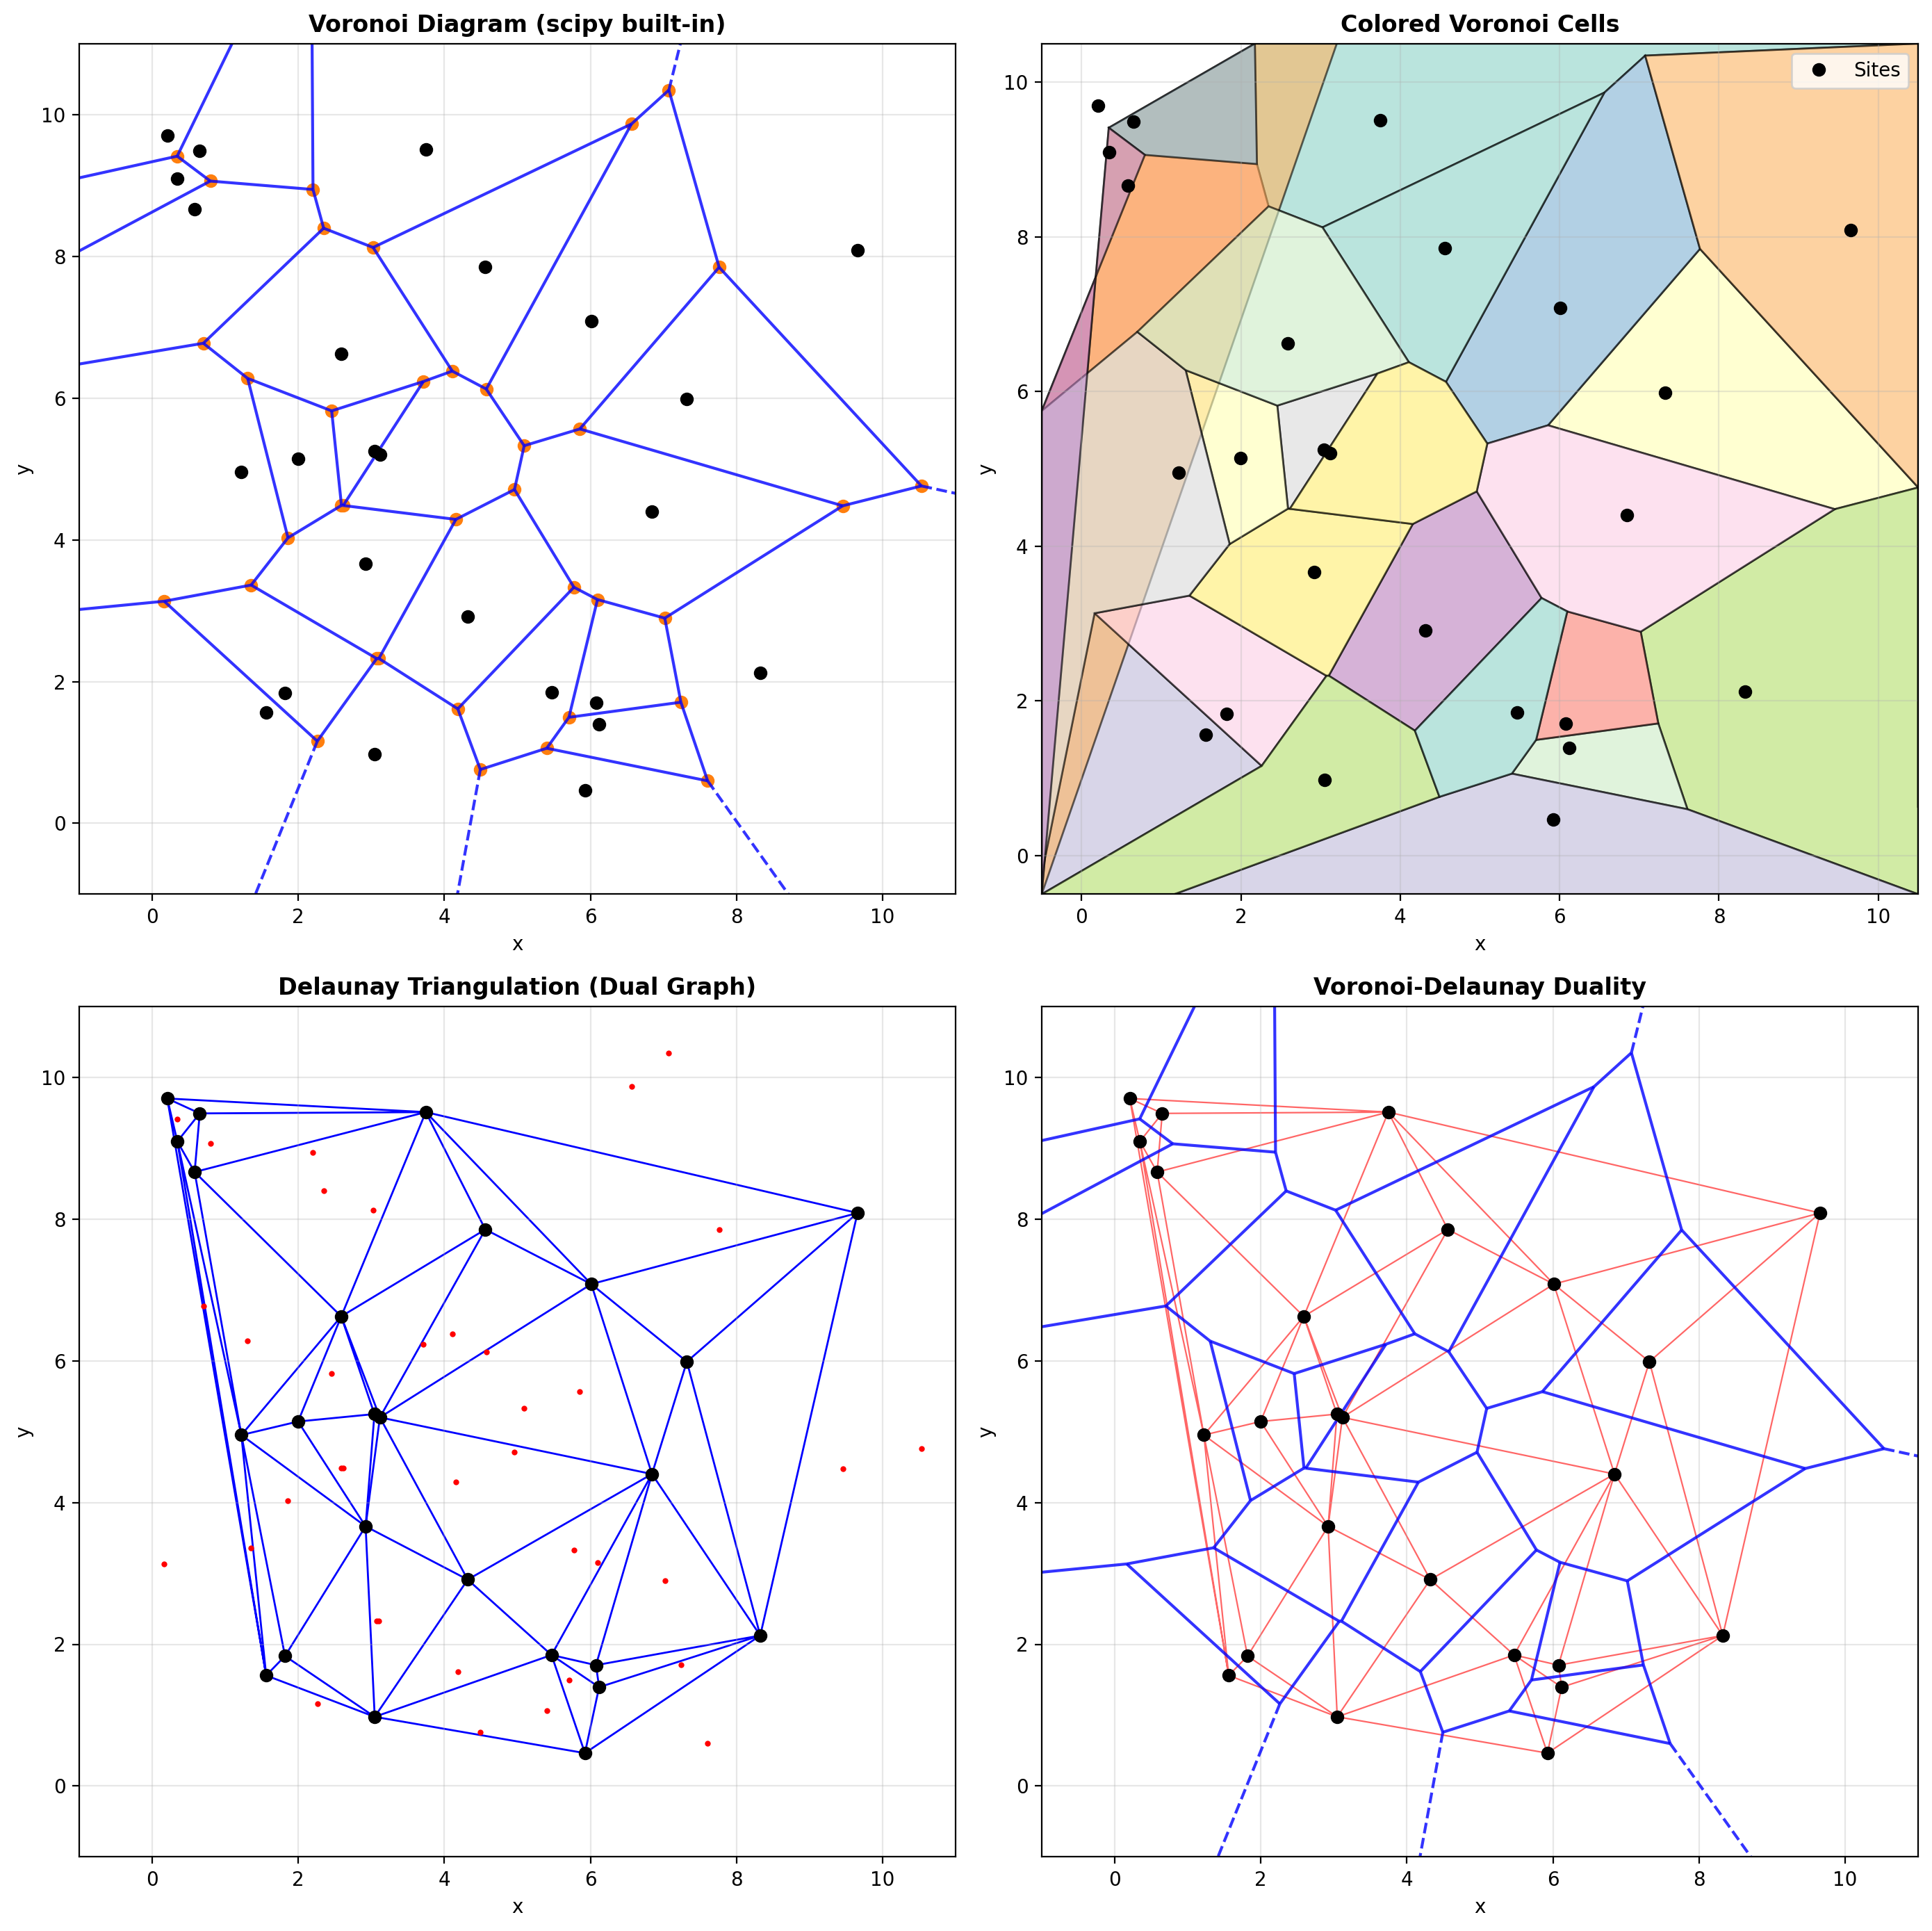


Visualization saved to 'plot.png'


In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot 1: Basic Voronoi diagram using scipy
ax1 = axes[0, 0]
voronoi_plot_2d(vor, ax=ax1, show_vertices=True, line_colors='blue',
                line_width=1.5, line_alpha=0.8, point_size=8)
ax1.plot(points[:, 0], points[:, 1], 'ko', markersize=6)
ax1.set_xlim(-1, 11)
ax1.set_ylim(-1, 11)
ax1.set_title('Voronoi Diagram (scipy built-in)', fontsize=12, fontweight='bold')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.grid(True, alpha=0.3)

# Plot 2: Colored Voronoi cells
ax2 = axes[0, 1]
cmap = plt.cm.Set3
for i, region in enumerate(regions):
    if len(region) > 0:
        polygon = vertices[region]
        # Clip to bounding box
        polygon = np.clip(polygon, -0.5, 10.5)
        ax2.fill(*zip(*polygon), alpha=0.6, 
                 facecolor=cmap(i % 12), edgecolor='black', linewidth=1)

ax2.plot(points[:, 0], points[:, 1], 'ko', markersize=6, label='Sites')
ax2.set_xlim(-0.5, 10.5)
ax2.set_ylim(-0.5, 10.5)
ax2.set_title('Colored Voronoi Cells', fontsize=12, fontweight='bold')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Delaunay triangulation (dual of Voronoi)
ax3 = axes[1, 0]
tri = Delaunay(points)
ax3.triplot(points[:, 0], points[:, 1], tri.simplices, 'b-', linewidth=1)
ax3.plot(points[:, 0], points[:, 1], 'ko', markersize=6)

# Show circumcenters (which are Voronoi vertices)
for simplex in tri.simplices:
    pts = points[simplex]
    # Compute circumcenter
    A = pts[0]
    B = pts[1]
    C = pts[2]
    D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))
    if abs(D) > 1e-10:
        ux = ((A[0]**2 + A[1]**2) * (B[1] - C[1]) + 
              (B[0]**2 + B[1]**2) * (C[1] - A[1]) + 
              (C[0]**2 + C[1]**2) * (A[1] - B[1])) / D
        uy = ((A[0]**2 + A[1]**2) * (C[0] - B[0]) + 
              (B[0]**2 + B[1]**2) * (A[0] - C[0]) + 
              (C[0]**2 + C[1]**2) * (B[0] - A[0])) / D
        ax3.plot(ux, uy, 'r.', markersize=4)

ax3.set_xlim(-1, 11)
ax3.set_ylim(-1, 11)
ax3.set_title('Delaunay Triangulation (Dual Graph)', fontsize=12, fontweight='bold')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.grid(True, alpha=0.3)

# Plot 4: Voronoi with Delaunay overlay
ax4 = axes[1, 1]
voronoi_plot_2d(vor, ax=ax4, show_vertices=False, line_colors='blue',
                line_width=1.5, line_alpha=0.8, point_size=0)
ax4.triplot(points[:, 0], points[:, 1], tri.simplices, 'r-', 
            linewidth=0.8, alpha=0.6)
ax4.plot(points[:, 0], points[:, 1], 'ko', markersize=6)
ax4.set_xlim(-1, 11)
ax4.set_ylim(-1, 11)
ax4.set_title('Voronoi-Delaunay Duality', fontsize=12, fontweight='bold')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'plot.png'")

In [5]:
# Compute and display statistics about Voronoi cells
print("Voronoi Cell Statistics:")
print("=" * 50)

# Calculate areas of bounded cells
def polygon_area(vertices):
    """Calculate polygon area using the shoelace formula."""
    n = len(vertices)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]
    return abs(area) / 2.0

areas = []
edge_counts = []

for i, region in enumerate(regions):
    if len(region) > 0:
        polygon = vertices[region]
        # Clip to reasonable bounds
        polygon_clipped = np.clip(polygon, 0, 10)
        area = polygon_area(polygon_clipped)
        if area > 0 and area < 100:  # Filter unreasonable areas
            areas.append(area)
            edge_counts.append(len(region))

areas = np.array(areas)
edge_counts = np.array(edge_counts)

print(f"\nCell Area Statistics:")
print(f"  Mean area: {np.mean(areas):.3f}")
print(f"  Std deviation: {np.std(areas):.3f}")
print(f"  Min area: {np.min(areas):.3f}")
print(f"  Max area: {np.max(areas):.3f}")

print(f"\nEdge Count Statistics:")
print(f"  Mean edges per cell: {np.mean(edge_counts):.2f}")
print(f"  Min edges: {np.min(edge_counts)}")
print(f"  Max edges: {np.max(edge_counts)}")

# Theoretical expectation: for random points, mean edges ≈ 6
print(f"\nTheoretical expectation for random points: ~6 edges per cell")

Voronoi Cell Statistics:

Cell Area Statistics:
  Mean area: 4.460
  Std deviation: 3.047
  Min area: 0.093
  Max area: 13.669

Edge Count Statistics:
  Mean edges per cell: 5.48
  Min edges: 4
  Max edges: 8

Theoretical expectation for random points: ~6 edges per cell


In [6]:
# Demonstrate nearest neighbor query using Voronoi
print("\nNearest Neighbor Query Demo:")
print("=" * 50)

# Query points
query_points = np.array([[2.5, 3.0], [7.0, 8.0], [5.0, 5.0]])

for i, q in enumerate(query_points):
    # Find nearest site
    distances = np.linalg.norm(points - q, axis=1)
    nearest_idx = np.argmin(distances)
    nearest_site = points[nearest_idx]
    min_dist = distances[nearest_idx]
    
    print(f"\nQuery point {i+1}: ({q[0]:.2f}, {q[1]:.2f})")
    print(f"  Nearest site: Site {nearest_idx} at ({nearest_site[0]:.2f}, {nearest_site[1]:.2f})")
    print(f"  Distance: {min_dist:.3f}")


Nearest Neighbor Query Demo:

Query point 1: (2.50, 3.00)
  Nearest site: Site 11 at (2.92, 3.66)
  Distance: 0.786

Query point 2: (7.00, 8.00)
  Nearest site: Site 4 at (6.01, 7.08)
  Distance: 1.350

Query point 3: (5.00, 5.00)
  Nearest site: Site 23 at (3.12, 5.20)
  Distance: 1.894


## Summary

This notebook demonstrated the construction and visualization of Voronoi diagrams, a fundamental data structure in computational geometry. Key concepts covered:

1. **Mathematical Foundation**: Voronoi cells partition space based on proximity to generator sites
2. **Geometric Properties**: Cells are convex polygons bounded by perpendicular bisectors
3. **Duality**: Voronoi diagrams are dual to Delaunay triangulations
4. **Complexity**: For $n$ sites, $O(n)$ vertices and $O(n)$ edges
5. **Applications**: Spatial queries, mesh generation, nearest neighbor search

The computational complexity of constructing a Voronoi diagram using Fortune's algorithm is $O(n \log n)$, making it efficient for large point sets.